# Model per detectar saques

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import pickle
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, Dense, Masking

## Preprocessament de les dades

In [2]:
# Load data
df = pd.read_csv("train_dataset.csv", index_col=0)
df.head()

,frame_A,minut,segon,X1,Y1,X2,Y2,X3,Y3,X4,Y4,Xpilota,Ypilota,Zpilota,primerosegon
0,2,0.0,0.08,2.173689,3.247462,16.204901,6.362625,5.596889,2.122023,17.891829,3.374809,5.525027,0.293553,0.278393,0
1,3,0.0,0.12,2.295734,3.184132,16.336478,6.299518,5.757917,1.981295,17.934269,3.335846,5.471187,0.246989,0.408650,0
2,4,0.0,0.16,2.258836,3.097047,16.240914,6.242256,5.632388,1.830908,18.059032,3.298770,5.418823,0.192745,0.552259,0
3,5,0.0,0.20,2.359201,3.012677,16.141232,6.206958,5.678033,1.703008,18.033313,3.250262,5.356726,0.133419,0.707505,0
4,6,0.0,0.24,2.345732,2.913717,15.910345,6.146682,5.586123,1.585131,18.129955,3.217609,5.289074,0.075366,0.860300,0


In [2]:
# df.to_csv('train_dataset_new_features.csv', index=False) 
df = pd.read_csv("train_dataset_new_features.csv")
# df.head()

### Noves variables de moviment

Les noves variables descriuen el moviment de cada jugador i la pilota calculat amb la diferència de la seva posició respecte un segon abans i un segon després.

In [3]:
# Iterem per cada jugador i per cada component per calcular quant s'ha mogut en l'últim segon (25 frames = 1 segon)
for i in range(1, 5):
    for j in ['X', 'Y']:
        mov_prev = df[f'{j}{i}'] - df[f'{j}{i}'].shift(50)
        mov_post = df[f'{j}{i}'].shift(-50) - df[f'{j}{i}']
        # Depen de la banda de la xarxa on es troben, moviment positiu i negatiu volen dir moures endavant o enrere

        x_value = df.at[i, f'X{i}']

        if x_value < 10:
            df[f'mov{j}{i}_prev'] = mov_prev
            df[f'mov{j}{i}_post'] = mov_post    
        else:
            df[f'mov{j}{i}_prev'] = -mov_prev
            df[f'mov{j}{i}_post'] = -mov_post

# Iterem per cada component de posició de la pilota per calcular quant s'ha mogut en l'últim segon (25 frames = 1 segon)
for i in ['X', 'Y', 'Z']:
    df[f'mov{i}pilota_prev'] = df[f'{i}pilota'] - df[f'{i}pilota'].shift(50)
    df[f'mov{i}pilota_post'] = df[f'{i}pilota'].shift(-50) - df[f'{i}pilota']

### Noves variables temporals
Nova variable que determina el temps des de l'últim moment en que un jugador no ha estat reconegut per la càmera (si estava fora el camp segurament era amb el joc parat i, per tant, hi haurà un saque per tornar a posar la pilota en joc)

In [4]:
# Funció per pasar juntar les dues variables de minuts i segons
def to_seconds(minutes, seconds):
    return minutes * 60 + seconds

# Funció per trobar el temps des de l'anterior valor null a les variables de posició
def time_since_previous_nan(row):
    time_in_seconds = to_seconds(row['minut'], row['segon']) # temps de la fila examinada en segons
    prev_nan = (df[['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'Xpilota', 'Ypilota', 'Zpilota']].isna().any(axis=1) & (df.index <= row.name)) # llista de tots els valors null abans d'aquesta fila
    previous_nan_indices = prev_nan[prev_nan].index.values # indexos de les files amb nulls abans d'aquesta
    if len(previous_nan_indices) == 0:
        # Si no hi ha hagut cap null encara, retornem el temps de la fila (temps des de l'inici del video)
        return time_in_seconds
    else:
        previous_nan_index = previous_nan_indices[-1] # index de l'últim valor nulls abans de la fila examinada
        if row.name == previous_nan_index:
            # si el aquesta fila conté un valor null retornem 0
            return 0
        else:
            # si hi ha un valor null abans de la fila examinada, calculem quant temps fa hi ho retornem
            previous_nan_time_in_seconds = to_seconds(df.loc[previous_nan_index, 'minut'], df.loc[previous_nan_index, 'segon'])
            return time_in_seconds - previous_nan_time_in_seconds

# Correm la funció per cada entrada del dataframe
df['time_prev_nan'] = df.apply(time_since_previous_nan, axis=1)


### Noves variables de posició
Mirant la importància que dona el model a cada feature, m'he adonat que hi ha molta diferència entre la importància de les posicions d'uns jugadors a uns altres. Això no té sentit ja que el saque va canviant, i per molt que un jugador es mogui més que un altre, quan el model es testegi amb un partit diferent aicò ja no será així. Per tant, potser trobar una variable que pugui englobar la posició de tots els jugadors en un sol feature pot ajudar. Faré servir a mitja de al distància del jugadors respecte a la xarxa. 

In [5]:
def distances(row):
    distances_net = np.zeros(4)
    distances_middle = np.zeros(4)
    for i in range(1,5):
        distances_net[i-1] = np.abs(row[f'X{i}']-10)
        distances_middle[i-1] = np.abs(row[f'Y{i}']-5)
    return pd.Series({'distances_net': distances_net.mean(), 'distances_middle': distances_middle.mean()})

df[['distances_net_all', 'distances_middle_all']] = df.apply(distances, axis=1)

In [ ]:
def distances_byteam(row):
    distances_net_tb = []
    distances_net_tnb = []
    distances_middle_tb =[]
    distances_middle_tnb =[]
    for i in range(1,5):
        if (row[f'X{i}']>10 and row['Xpilota']>10) or (row[f'X{i}']<10 and row['Xpilota']<10):
            distances_net_tb.append(np.abs(row[f'X{i}']-10))
            distances_middle_tb.append(np.abs(row[f'Y{i}']-5))
        else:
            distances_net_tnb.append(np.abs(row[f'X{i}']-10))
            distances_middle_tnb.append(np.abs(row[f'Y{i}']-5))
    return pd.Series({
        'distances_net_tb': np.array(distances_net_tb).mean(), 
        'distances_net_tnb': np.array(distances_net_tnb).mean(),
        'distances_middle_tb': np.array(distances_middle_tb).mean(), 
        'distances_middle_tnb': np.array(distances_middle_tnb).mean()
        })

df[['distances_net_tb', 'distances_net_tnb', 'distances_middle_tb', 'distances_middle_tnb']] = df.apply(distances_byteam, axis=1)

### Noves variables de moviment per equip
Agrupem els moviments de jugador per equip. Separem entre equip amb pilota i equip sense pilota.

In [ ]:
def mov_byteam(row):
    movX_prev_tb = []
    movX_post_tb = []
    movY_prev_tb = []
    movY_post_tb = []
    movX_prev_tnb = []
    movX_post_tnb = []
    movY_prev_tnb = []
    movY_post_tnb = []
    for i in range(1,5):
        if (row[f'X{i}']>10 and row['Xpilota']>10) or (row[f'X{i}']<10 and row['Xpilota']<10):
            movX_prev_tb.append(row[f'movX{i}_prev'])
            movX_post_tb.append(row[f'movX{i}_post'])
            movY_prev_tb.append(row[f'movY{i}_prev'])
            movY_post_tb.append(row[f'movY{i}_post'])
        else:
            movX_prev_tnb.append(row[f'movX{i}_prev'])
            movX_post_tnb.append(row[f'movX{i}_post'])
            movY_prev_tnb.append(row[f'movY{i}_prev'])
            movY_post_tnb.append(row[f'movY{i}_post'])
    return pd.Series({
        'movX_prev_tb': np.array(movX_prev_tb).mean(),
        'movX_post_tb': np.array(movX_post_tb).mean(),
        'movY_prev_tb': np.array(movY_prev_tb).mean(),
        'movY_post_tb': np.array(movY_post_tb).mean(),
        'movX_prev_tnb': np.array(movX_prev_tnb).mean(),
        'movX_post_tnb': np.array(movX_post_tnb).mean(),
        'movY_prev_tnb': np.array(movY_prev_tnb).mean(),
        'movY_post_tnb': np.array(movY_post_tnb).mean()
    })
    

df[['movX_prev_tb', 'movX_post_tb', 'movY_prev_tb', 'movY_post_tb', 'movX_prev_tnb', 'movX_post_tnb', 'movY_prev_tnb', 'movY_post_tnb']] = df.apply(mov_byteam, axis=1)

### Valors null i altres processaments

Primer tractem els valors null

In [9]:
# Check valors Nan
df.isnull().any()

frame_A                 False
minut                   False
segon                   False
X1                       True
Y1                       True
X2                       True
Y2                       True
X3                       True
Y3                       True
X4                       True
Y4                       True
Xpilota                 False
Ypilota                 False
Zpilota                 False
primerosegon            False
movX1_prev               True
movX1_post               True
movY1_prev               True
movY1_post               True
movX2_prev               True
movX2_post               True
movY2_prev               True
movY2_post               True
movX3_prev               True
movX3_post               True
movY3_prev               True
movY3_post               True
movX4_prev               True
movX4_post               True
movY4_prev               True
movY4_post               True
movXpilota_prev          True
movXpilota_post          True
movYpilota

Veiem que només les variables de les posicions dels jugadors les tenen valors nulls (apart de les de moviment). Fent una ullada a les dades m'ha semblat que sempre que falta el valor d'una variable també falta el de la seva parella (coordenades, si falta la x falta la y), per tant, entenc que no és problema del dataframe sinó que és que el jugador no s'ha pogut identificar a la pista. Per tant, entenc que el jugador no està a la pista i es pot descartar que sigui un frame de saque. No se com de bé funciona l'algoritme, però un altre motiu pel que potser no es pot detectar un jugador és perqué està junt amb el seu company i l'algoritme ho detecta com una sola persona. En aquest cas, també es pot descartar que es tracti d'una sacada ja que els jugadors sempre estaries ben posicionats a la pista.

In [3]:
# Drop NaN
df_nonan = df.dropna() # Drop rows containing NaN values

In [4]:
# Separar el target
target_column = df_nonan['primerosegon']
df_notarget = df_nonan.drop('primerosegon',axis=1)

## Models de classificació

In [5]:
# Separar train i test
x_train, x_test, y_train, y_test = train_test_split(df_notarget, target_column, test_size=0.20, shuffle=False, random_state=1)

print('x_train:',np.shape(x_train))
print('y_train:',np.shape(y_train))
print('x_test:',np.shape(x_test))
print('y_test:',np.shape(y_test))

x_train: (30730, 51)
y_train: (30730,)
x_test: (7683, 51)
y_test: (7683,)


In [6]:
# Número de frames de saque vs no saque
y_train.value_counts()

0    30677
1       53
Name: primerosegon, dtype: int64

Al tenir un dataset amb tots els frames d'un partit, n'hi ha molts més que no són de saque que els si ho són (99.9% vs 0.1%), tenim un dataset molt imbalanced. A l'entrenar un model amb aquestes dades ens detecta la majoria de frames com a No Saque, i molt rarament detecta correctament un frame de Saque. Per tant, tractem aquestes dades primer fent un resample. El que fem es repetir altres frames de saque per a que el número estigui més igualat (upsample). Com més frames creem, més frames de saque detectarà, tan que són saque realment com que no ho són. Per tant es un paràmetre a tenir en compte al pensar com d'important és deixar passar saques o detectar frames que no són saque com a saques. Tamabé es poden eliminar frames de no saque.

In [7]:
# Concatenar les dades amb el target
train_data = x_train.assign(target = y_train.values)

# Separar entre saque i no saque
saque_train = train_data[train_data["target"] == 1]
nosaque_train = train_data[train_data["target"] == 0]

# Resample (crear nous frames de saque) (també es pot fer downsample (eliminar frames de no saque))
saque_upsampled = resample(saque_train, replace=True, n_samples=int(len(nosaque_train)/2), random_state=0)
nosaque_downsampled = resample(nosaque_train, replace=False, n_samples=len(saque_train*2), random_state=0)

# Juntar de nou els frames de saque ambe els de no saque
# resampled_train = pd.concat([nosaque_train, saque_upsampled]) # Upsampling
resampled_train = pd.concat([nosaque_downsampled, saque_train]) # Downsampling

# Separar dades i target
y_train_resampled = resampled_train['target']
x_train_resampled = resampled_train.drop('target',axis=1)

Feature selection - triem els features que volem passar al model

In [8]:
feature_names = ['distances_net_tb', 'distances_net_tnb', 'distances_middle_tb', 'distances_middle_tnb', 'time_prev_nan', 'movX_prev_tb', 'movX_post_tb', 'movYprev_tb', 'movY_post_tb', 'movX_prev_tnb', 'movX_post_tnb', 'movYprev_tnb', 'movY_post_tnb']
# feature_names = ['distances_net_tb', 'distances_net_tnb', 'distances_middle_tb', 'distances_middle_tnb', 'movX_prev_tb', 'movYprev_tb', 'movX_prev_tnb', 'movYprev_tnb']
x_train_features = x_train_resampled.loc[:, feature_names]
x_test_features = x_test.loc[:, feature_names]

### Logistic regression

#### Valors default

In [30]:
# Crear el model
logisticRegr = LogisticRegression()

In [31]:
# Entrenar el model
logisticRegr.fit(x_train_features, y_train_resampled)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
# Clasificar els frames del test com a saque o no saque
y_pred = logisticRegr.predict(x_test_features)

In [33]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[3374, 4288],
       [   6,   15]], dtype=int64)

#### Fine tuning
Per trobar els paràmetres amb els que funciona millor el model fem servir GridSearchCV que el que fa es probarlos tots i retornar els que millor resultats obtenen.

In [34]:
# Paràmetres a provar
param_grid = {
    'penalty': ['l1', 'l2'],            # Penalty type: L1 or L2 regularization
    'C': [0.001, 0.01, 0.1, 1, 10, 100],# Regularization strength
    'solver': ['liblinear', 'saga'],    # Solver algorithm - liblinear for small datasets
    'class_weight': [None, 'balanced'], # Class weight
    'tol': [1e-4, 1e-3, 1e-2],          # Tolerance for stopping criteria
}

# Crear els models i retornar els paràmetres que funcionen millor
logisticRegr = LogisticRegression(max_iter=10000)
logisticRegr_cv=GridSearchCV(logisticRegr,param_grid,cv=10,scoring='f1')
logisticRegr_cv.fit(x_train_features,y_train_resampled)
print("best parameters: ",logisticRegr_cv.best_params_)

best parameters:  {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}


In [35]:
# Clasificar els frames del test com a saque o no saque
y_pred = logisticRegr_cv.predict(x_test_features)

In [36]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[5136, 2526],
       [   7,   14]], dtype=int64)

<AxesSubplot: ylabel='Feature'>

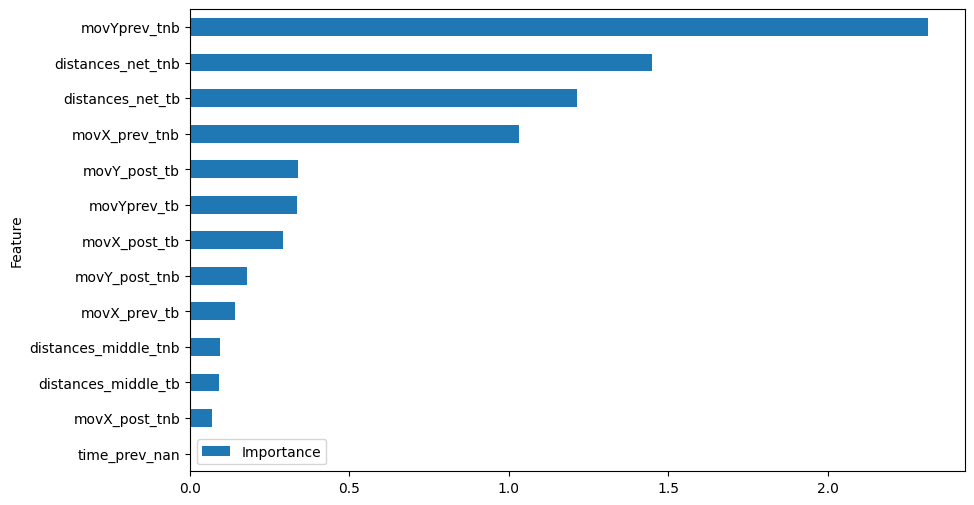

In [37]:
coef = logisticRegr_cv.best_estimator_.coef_[0]

feature_importance = pd.DataFrame({'Feature': x_train_features.columns, 'Importance': np.abs(coef)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

### Random Forest

#### Valors default

In [33]:
# Crear el model
rf = RandomForestClassifier()

In [34]:
# Entrenar el model
rf.fit(x_train_features, y_train_resampled)

RandomForestClassifier()

In [35]:
# Clasificar els frames del test com a saque o no saque
y_pred = rf.predict(x_test_features)

In [41]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[6058, 1604],
       [   7,   14]], dtype=int64)

#### Fine tuning
Per trobar els paràmetres amb els que funciona millor el model fem servir GridSearchCV que el que fa es probarlos tots i retornar els que millor resultats obtenen.

In [36]:
# Paràmetres a provar
param_grid = { 
    'n_estimators': [50, 100, 200, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3,5,10,20,40],
    'criterion' :['gini', 'entropy']
}

# Crear els models i retornar els paràmetres que funcionen millor
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid, cv= 10, scoring='f1')
rf_cv.fit(x_train_features, y_train_resampled)
print("best parameters: ", rf_cv.best_params_)


best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 200}


In [37]:
# Clasificar els frames del test com a saque o no saque
y_pred = rf_cv.predict(x_test_features)

In [38]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[6071, 1590],
       [   3,   19]], dtype=int64)

In [21]:
metrics.f1_score(y_test, y_pred)

0.025236593059936908

<AxesSubplot: ylabel='Feature'>

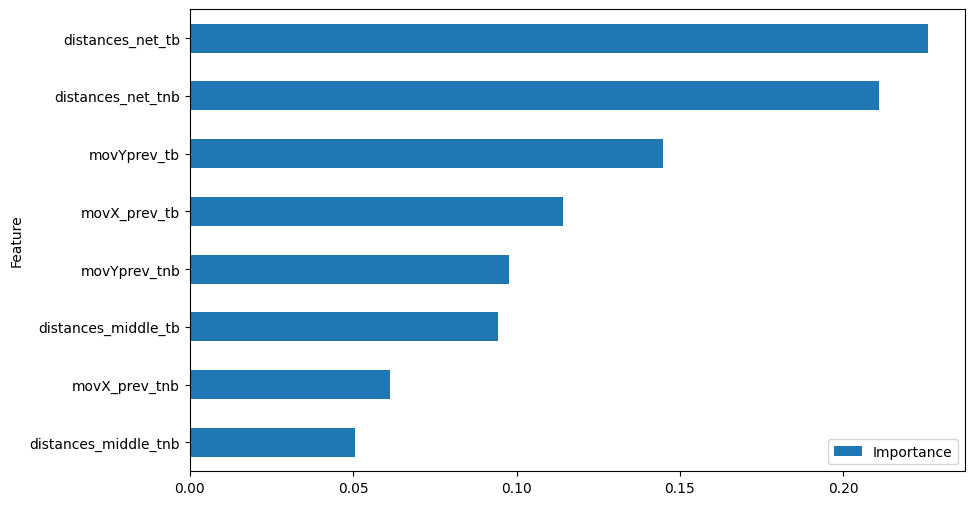

In [39]:
coef = rf_cv.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': x_train_features.columns, 'Importance': np.abs(coef)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

### SVM

#### Valors default

In [46]:
# Crear model
svmm = svm.SVC() # Linear Kernel

In [47]:
# Entrenar model
svmm.fit(x_train_features, y_train_resampled)


SVC()

In [48]:
# Clasificar els frames del test com a saque o no saque
y_pred = svmm.predict(x_test_features)

In [49]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[2812, 4850],
       [   6,   15]], dtype=int64)

#### Fine tunnig
Per trobar els paràmetres amb els que funciona millor el model fem servir GridSearchCV que el que fa es probarlos tots i retornar els que millor resultats obtenen.

In [50]:
# Paràmetres a provar
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['linear', 'poly', 'rbf']
}

# Crear els models i retornar els paràmetres que funcionen millor
svmm = svm.SVC() # Linear Kernel
svm_cv = GridSearchCV(svmm, param_grid, cv= 10, scoring='f1')
svm_cv.fit(x_train_features, y_train_resampled)
print("best parameters: ",svm_cv.best_params_)

In [ ]:
# Clasificar els frames del test com a saque o no saque
y_pred = svm_cv.predict(x_test_features)

In [ ]:
# Confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[6452, 1299],
       [   5,   10]], dtype=int64)

In [ ]:
coef = svm_cv.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'Feature': x_train_features.columns, 'Importance': np.abs(coef)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

### Bidirectional RNN
Recurrent Neural Networs són models que es fan servir per classificar dades sequencials com són els frames d'un video. Implementem bidireccional perquè fa servir frames passats com futurs, i això ens interssa perque pot seterminar com els jugadors i pilota es mouen abans i després del saque.

In [57]:
# Crear el model
brnn = Sequential()
num_neurons = 64
num_features = len(feature_names)
# brnn.add(Bidirectional(LSTM(num_neurons, return_sequences=False), input_shape=(None, num_features)))
brnn.add(Bidirectional(GRU(num_neurons, return_sequences=False), input_shape=(None, num_features)))
brnn.add(Dense(1, activation='sigmoid'))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# Compile the model
brnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
brnn.fit(x_train_features, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)

# Error

Sembla que aquest tipus de model només funciona amb sequencies de frames i cada una com a un sol Saque/No saque. Jo estava intentant que funciones per categorizar frame per frame.

Ara provo fer-ho amb un RNN més simple però que no te en compte la informació temporal entre els frames. Per tant crec que no guanyem res.

In [45]:
# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(num_features,)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train_features, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5830 - loss: 36.5136 - val_accuracy: 0.0000e+00 - val_loss: 33.2254
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6337 - loss: 26.4856 - val_accuracy: 0.0000e+00 - val_loss: 29.0523
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6280 - loss: 24.2924 - val_accuracy: 0.0000e+00 - val_loss: 24.7764
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6866 - loss: 20.9068 - val_accuracy: 0.0455 - val_loss: 20.5154
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5908 - loss: 19.8124 - val_accuracy: 0.0909 - val_loss: 16.2108
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5653 - loss: 16.8609 - val_accuracy: 0.1364 - val_loss: 12.0284
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5965 - loss: 11.1730 - val_accuracy: 0.1818 - val_loss: 8.0049
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5201 - loss: 8.5711 - val_accuracy: 0.3636 - va

In [53]:
y_pred = model.predict(x_test_features)

  1/241 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [54]:
y_pred = y_pred>0.994107 # Filtre fet a ull per triar els millor 23 (test)
y_pred = y_pred*1 # passem de True/False a 1/0

In [55]:
metrics.confusion_matrix(y_test, y_pred)

array([[7638,   23],
       [  22,    0]], dtype=int64)

El model amb RNN no ha funcionat, crec que el millor és seguir amb els models anterior encara que tampoc haguem conseguit incloure variables que continguin informació temporal que facin millorar la bondat de l'algortime.

## Model final

Dels 3 models provats, el que funciona millor amb aquest dataset és Random Forest. Detecta correctament els mateix número de frames de saque que Logistic Regression però amb un número de falsos positius menor. Per altra banda, retorna més falsos positius que SVM però no deixa escapar tants frames de saque com ho fa aquest segon model. He decidit que en aquest cas interesava augmentar el número de frames de saque detectats correctament encara que això també faci augmentar els falsos positius. Això suposo que depén de l'aplicació d'aquests frames detectats, però he pensat que era bó detectar tant com possibles per si després es pugués pasar per algún altre tipus de filtre que pugui eliminar més clarament els falsos positius i conseguir tenir gairebé tots els saques que s'han produït durant tot el video. 

In [22]:
# Guardem el model per poder-lo fer servir més endavamt en altres documents.
model = rf_cv
# model = pickle.load(open("model_saques.sav", 'rb'))
# pickle.dump(model, open("model_saques_v2.sav", 'wb'))

### Filtres lògics previs

Ordenem per index per poder després recuperar l'ordre inicial

In [25]:
x_test_nw_index = x_test.reset_index(drop=True)

#### Posició Pilota

Si la pilota no està per darrere la línea de saque, no pot ser un frame de saque. La línea de saque està a 3 metres del vidres (x==3 i x==17), deixem 15 centimetres de marge.\
Si la pilota no està a l'alçada de la cadera, no pot ser un frame de saque.

He decidit no aplicar aquest filtre perquè mirant els frames que s'han etiquetat com a saque, aquest filtre no té sentit. Hi ha molts frames etiquetats com a saque que no passarien el filtre: la pilota darrere la línea (component X) i/o no està a l'alçada de saque (component Z).

In [ ]:
x_pil_saq = x_test_nw_index[
    ((x_test_nw_index['Xpilota']<3.15) | (x_test_nw_index['Xpilota']>16.85)) & # pilota darrere linea de saque
    ((x_test_nw_index['Zpilota']>0.50) | (x_test_nw_index['Zpilota']<1.10)) # pilota alçada cadera
    ]


#### Posició jugadors

Si no hi ha un jugador de cada equip com a mínim darrere la línea de saque, no pot ser un frame de saque.

In [26]:
def one_player_team_line(row):
    # Funció que retorna True si hi ha un jugador per equip mínim darrere la línea de saque i False si no n'hi ha
    tb = tnb = False 
    for i in range(1,5):
        # iterem pels jugadors
        if row[f'X{i}']<3.15 or row[f'X{i}']>16.85:
            # Si el jugador està darrere la linea de sques
            if (row[f'X{i}']>10 and row['Xpilota']>10) or (row[f'X{i}']<10 and row['Xpilota']<10):
                # si la pilota està al mateix camp que el jugador
                tb = True
            else:
                # si la pilota està al camp contrari
                tnb = True
    return tb and tnb 

x_jug_saq = x_test_nw_index[x_test_nw_index.apply(one_player_team_line, axis=1)]

#### Tots a la pista
Si algún jugador o la pilota no es troba a càmera, assumirem que el joc està parat i, per tant, no pot ser un frame de saque

In [27]:
x_tots = x_jug_saq.dropna()

### Apliquem el model

In [28]:
x_model = x_tots.loc[:, feature_names] # seleccionem els features amb els que s'ha entrenat el model
y_pred_jug_saq = model.predict(x_model)

In [29]:
y_pred = np.zeros(len(x_test_features), dtype=int) # Creem array de zeros (zero vol dir No saque)
y_pred[x_jug_saq.index] = y_pred_jug_saq # Introduïm a l'array els output del model només als index que han passat pel model, els altres ja s'han filtrat com a que són No saque

In [30]:
metrics.confusion_matrix(y_test, y_pred)

array([[6440, 1221],
       [   2,   20]], dtype=int64)

Els filtres no milloren gaire la bondat del model, encara hi ha masses falsos positius.